In [1]:

from __future__ import print_function, division

import torch
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import os
import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from HelperFns import *

In [2]:
path = "data/integrated_grad_ex/"
example_imgs = []
tenseUp = transforms.ToTensor()
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
for i in range(1, 7):
    example_imgs.append(Image.open(path + "0" + str(i) + ".jpg"))
    example_imgs[-1] = norm(tenseUp(example_imgs[-1]))

In [3]:
model = models.resnet18(pretrained=True).cuda()

In [4]:
"""
Computes an attribution vector by the integrated gradient method described in Axiomatic Attribution for Neural Networks for a single image.
Assumes input is a single color image with 3 dimensions (channel, width, height)
Returns an attribution tensor of same dimensions as input image
"""
def attribute(model, image, base, steps = 100, target = None, 
              output_activation = lambda x: x): 
    for param in model.parameters():
        param.requires_grad = True
    model.eval()
    baseShape = base.shape
    imageShape = image.shape
    baseBatch = base.view(1, baseShape[0], baseShape[1], baseShape[2])
    imageBatch = image.view(1, imageShape[0], imageShape[1], imageShape[2])
    baseScore = model(baseBatch)
    inScore = model(imageBatch)
    if target == None:
        target = torch.argmax(inScore[0])
    gradSum = torch.zeros([1, imageShape[0], imageShape[1], imageShape[2]], device=image.device)
    diff = imageBatch - baseBatch
    imshow(image.detach().cpu())
    
    for i in range(steps):
        new = baseBatch + diff * (float(i) / steps)
        new.requires_grad = True
        newShape = new.shape
        model.zero_grad()
        out = model(new)
        out = output_activation(out)
        out[0][target].backward()
        gradTensor = new.grad
        gradSum += gradTensor
            
    gradSum /= steps
    result = gradSum * diff
    baseSum = output_activation(baseScore)[0][target]
    diffSum = output_activation(inScore)[0][target] - baseSum
    resultSum = torch.sum(result)
    print("gradients vs score diff: ", abs((resultSum - diffSum)/diffSum).item() * 100,  "%")
    print("gradientSum: ", resultSum.item(), "diffSum: ", diffSum.item())
    return result, torch.argmax(out[0])

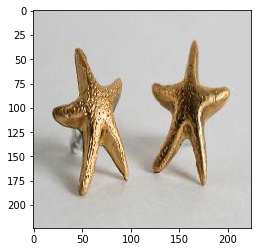

gradients vs score diff:  0.272247102111578 %
gradientSum:  0.9718085527420044 diffSum:  0.9744614958763123


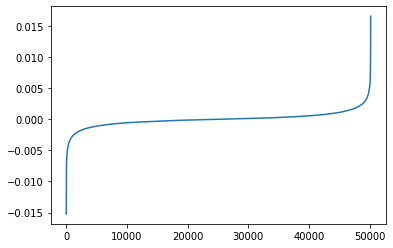

orig min  tensor(-0.0152, device='cuda:0')
minval:  tensor(0.0003, device='cuda:0')
orig max  tensor(0.0163, device='cuda:0')
maxVal:  tensor(0.0034, device='cuda:0')


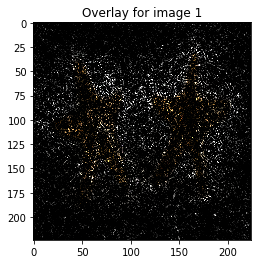

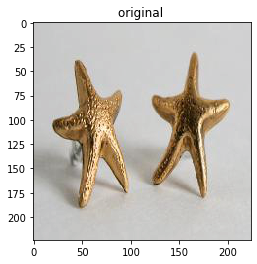

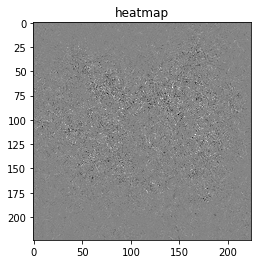

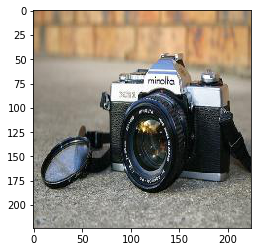

gradients vs score diff:  0.9526193141937256 %
gradientSum:  1.0077764987945557 diffSum:  0.9982668161392212


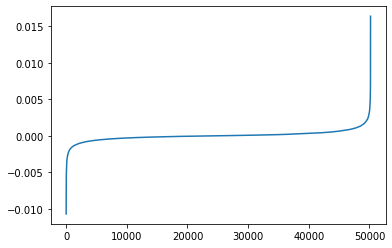

orig min  tensor(-0.0107, device='cuda:0')
minval:  tensor(0.0002, device='cuda:0')
orig max  tensor(0.0162, device='cuda:0')
maxVal:  tensor(0.0021, device='cuda:0')


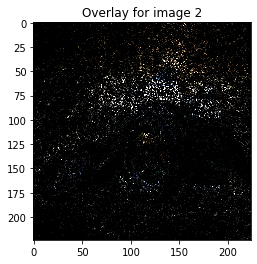

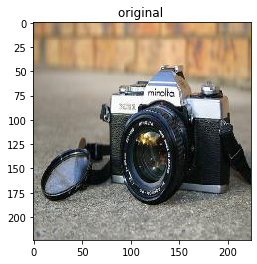

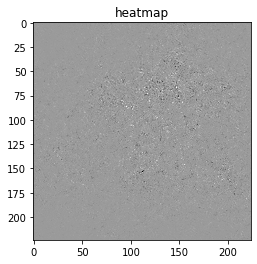

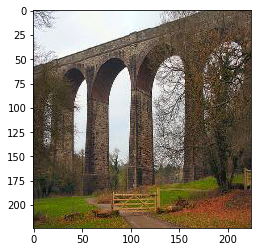

gradients vs score diff:  0.3352505387738347 %
gradientSum:  1.0031793117523193 diffSum:  0.9998273849487305


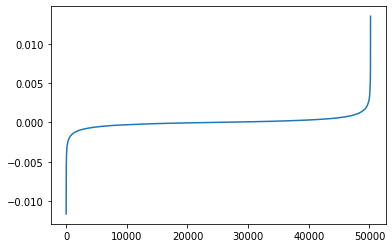

orig min  tensor(-0.0116, device='cuda:0')
minval:  tensor(0.0002, device='cuda:0')
orig max  tensor(0.0133, device='cuda:0')
maxVal:  tensor(0.0020, device='cuda:0')


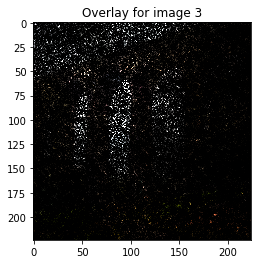

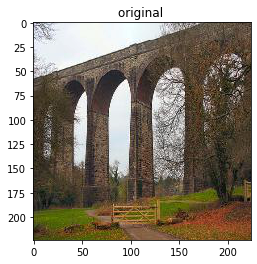

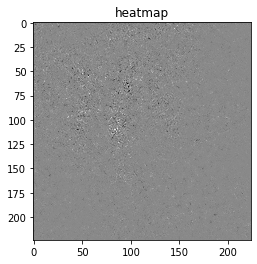

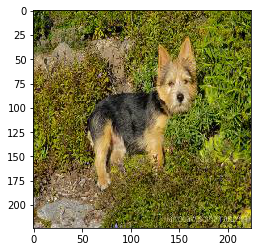

gradients vs score diff:  0.5427995696663857 %
gradientSum:  0.771856427192688 diffSum:  0.776068925857544


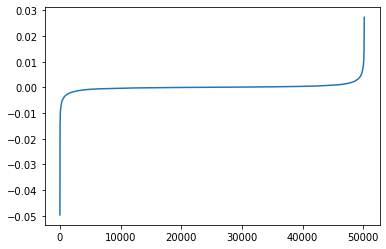

orig min  tensor(-0.0497, device='cuda:0')
minval:  tensor(0.0002, device='cuda:0')
orig max  tensor(0.0271, device='cuda:0')
maxVal:  tensor(0.0048, device='cuda:0')


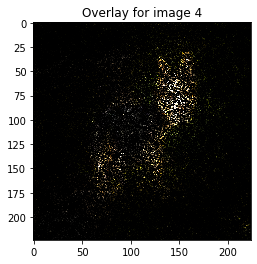

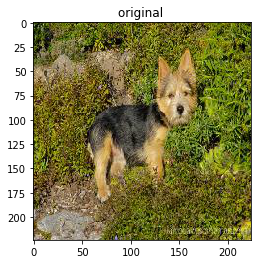

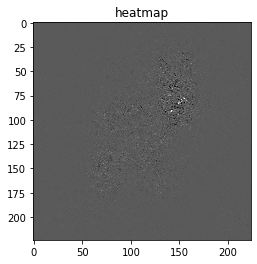

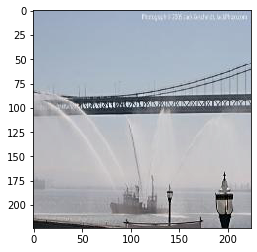

gradients vs score diff:  3.8753561675548553 %
gradientSum:  0.9544714689254761 diffSum:  0.9188622832298279


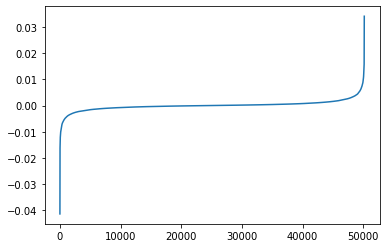

orig min  tensor(-0.0414, device='cuda:0')
minval:  tensor(0.0004, device='cuda:0')
orig max  tensor(0.0337, device='cuda:0')
maxVal:  tensor(0.0063, device='cuda:0')


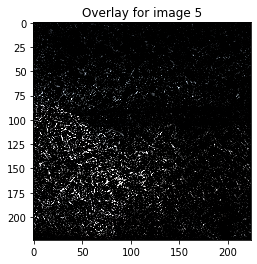

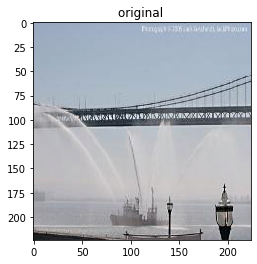

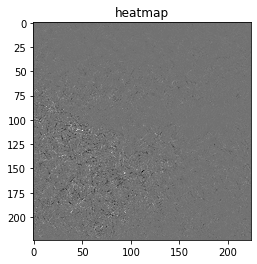

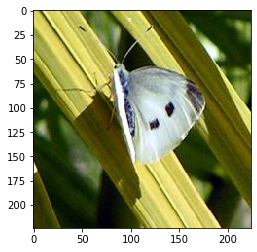

gradients vs score diff:  2.751486748456955 %
gradientSum:  0.8871625661849976 diffSum:  0.8634060621261597


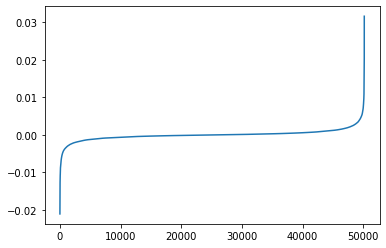

orig min  tensor(-0.0211, device='cuda:0')
minval:  tensor(0.0003, device='cuda:0')
orig max  tensor(0.0313, device='cuda:0')
maxVal:  tensor(0.0046, device='cuda:0')


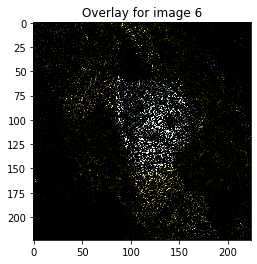

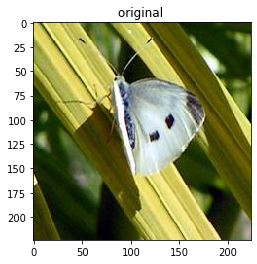

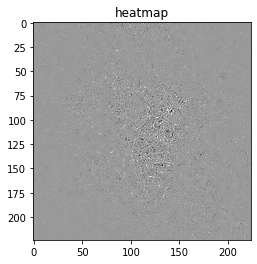

In [8]:
black_base = black_like(example_imgs[0].cuda(), torch.tensor(means).cuda(), torch.tensor(stds).cuda())
noise_base = noise_like(example_imgs[0].cuda(), torch.tensor(means).cuda(), torch.tensor(stds).cuda())
for i in range(6):
    att, _ = attribute(model, example_imgs[i].cuda(), noise_base, 100,
                       output_activation = lambda x: F.softmax(x, dim = 1))
    att_sum = att.sum(axis = 1)[0]
    flat = torch.flatten(att_sum)
    sorted, _ = torch.sort(flat)
    plt.plot(sorted.cpu())
    plt.show()
    plt.pause(0.1)
    simple_scale(att_sum, 1, 70)
    att_imshow(example_imgs[i].cpu(), att_sum.cpu(), "Overlay for image " + str(i + 1))
    imshow(example_imgs[i].cpu(), "original ")
    heatmap_imshow(att_sum.cpu(), "heatmap")